In [11]:
%matplotlib inline
# define functions for analysis
def missing(dataset):
    print(dataset.apply(lambda x: sum(x.isnull().values), axis = 0))

def frequency(dataset):
        for col in dataset:
            print(dataset.groupby(col).size())

# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:
# Bring in training dataset
train_data=pd.read_csv("/Users/geoffrey.kip/Projects/customer_churn_ml/train.csv")
test_data=pd.read_csv("/Users/geoffrey.kip/Projects/customer_churn_ml/test.csv")

In [4]:
# Check column types
train_data.dtypes
test_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [5]:
#check missing values
missing(train_data)
missing(test_data)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [6]:
# Exploratory Data Analysis
# Out of the females that are independent, what percentage of them have a monthly charge of greater than $20?
independent_females= train_data[(train_data['Dependents']== "No") & (train_data['gender'] == "Female")]
print(float(len(independent_females[independent_females['MonthlyCharges'] > 20]))/float(len(independent_females)))

# 92 % of all independent females have a total monthly charges greater than $20


0.924242424242


In [7]:
eda_dataset= train_data.set_index(['customerID'])

#check frequency distribution of all categorical variables
frequency(eda_dataset.select_dtypes(include=[np.object]))


gender
Female    2796
Male      2838
dtype: int64
Partner
No     2890
Yes    2744
dtype: int64
Dependents
No     3958
Yes    1676
dtype: int64
PhoneService
No      548
Yes    5086
dtype: int64
MultipleLines
No                  2727
No phone service     548
Yes                 2359
dtype: int64
InternetService
DSL            1929
Fiber optic    2468
No             1237
dtype: int64
OnlineSecurity
No                     2786
No internet service    1237
Yes                    1611
dtype: int64
OnlineBackup
No                     2478
No internet service    1237
Yes                    1919
dtype: int64
DeviceProtection
No                     2438
No internet service    1237
Yes                    1959
dtype: int64
TechSupport
No                     2765
No internet service    1237
Yes                    1632
dtype: int64
StreamingTV
No                     2249
No internet service    1237
Yes                    2148
dtype: int64
StreamingMovies
No                     2222
No internet servic

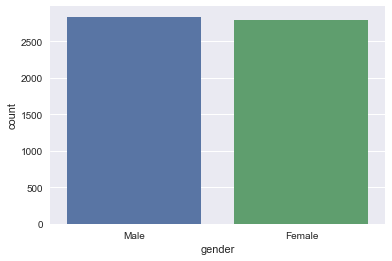

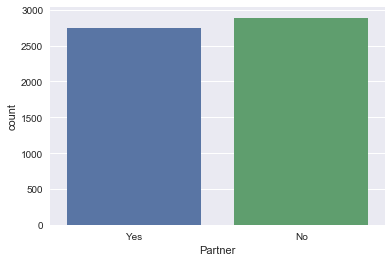

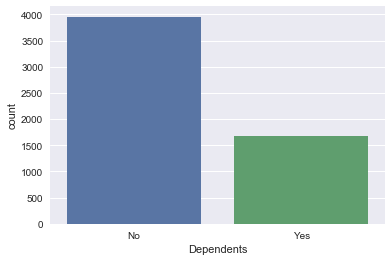

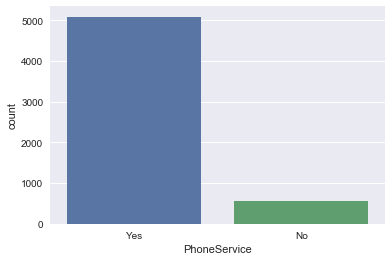

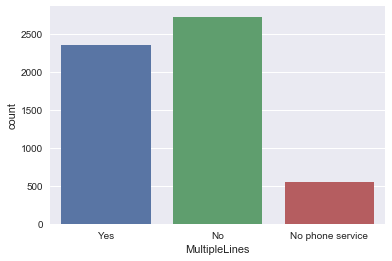

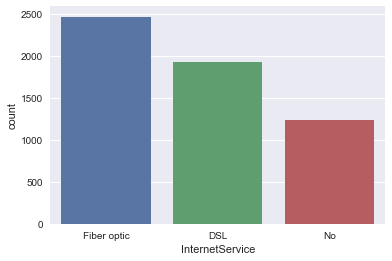

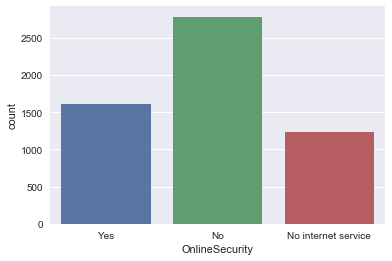

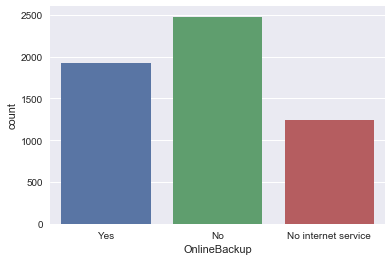

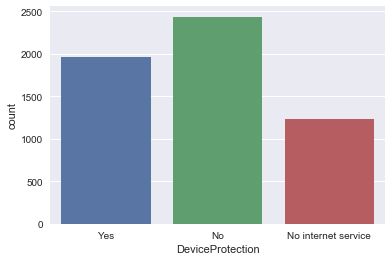

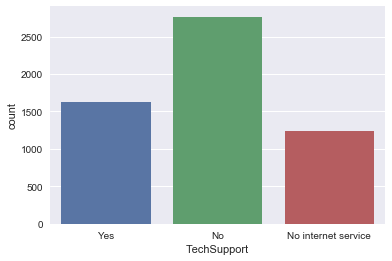

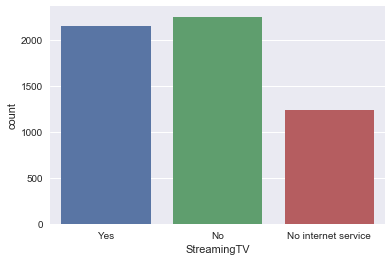

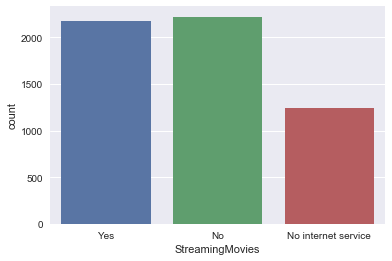

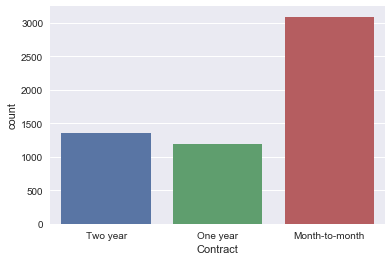

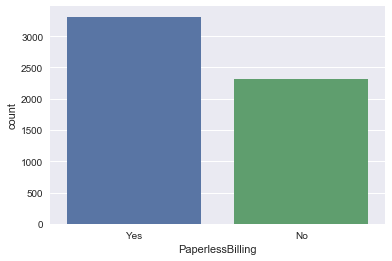

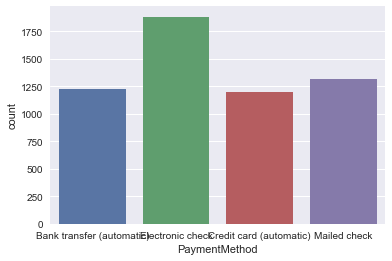

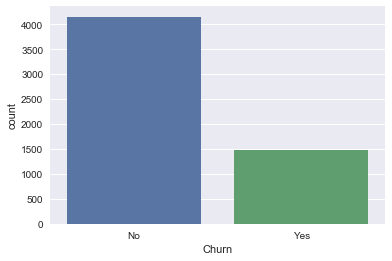

In [12]:
#Print countplots for all categorical variables
for i, col in enumerate(eda_dataset.select_dtypes(include=[np.object]).columns):
    plt.figure(i)
    sns.countplot(x=col, data=eda_dataset)
   

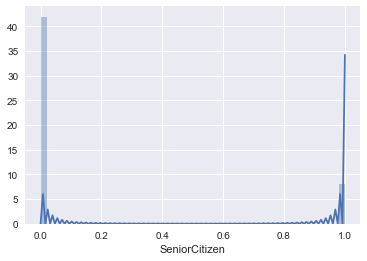

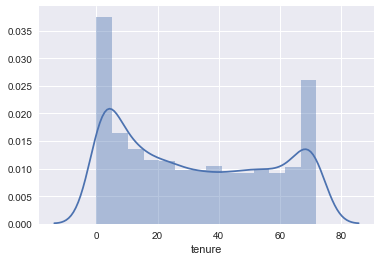

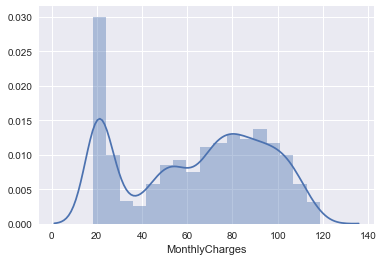

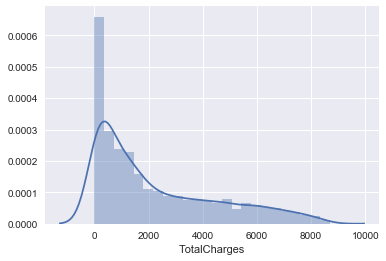

In [13]:
# Print distribuitons for all continuos variables
for i, col in enumerate(eda_dataset.select_dtypes(include=[np.float64,np.int64]).columns):
    plt.figure(i)
    sns.distplot(eda_dataset[col])


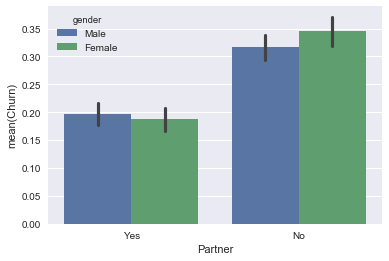

In [14]:
# Compare label against some variables
eda_dataset['Churn']= np.where(eda_dataset["Churn"] == "Yes",1,0)
sns.barplot(x="Partner", y="Churn",hue="gender", data=eda_dataset)


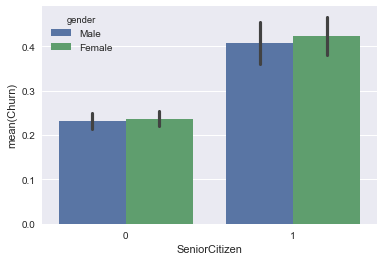

In [15]:
sns.barplot(x="SeniorCitizen", y="Churn",hue="gender", data=eda_dataset)


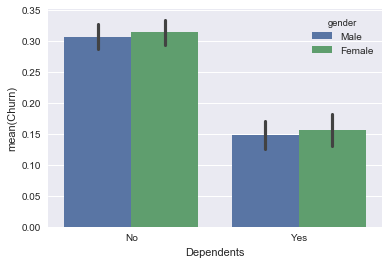

In [16]:
sns.barplot(x="Dependents", y="Churn",hue="gender", data=eda_dataset)

In [17]:
#Seperate labels from other features
labels=train_data[["customerID", "Churn"]]
labels=labels.set_index(['customerID'])
labels["Churn"]= np.where(labels["Churn"] == "Yes",1,0)

train_data= train_data.drop(["Churn"],axis=1)

# Convert Senior Citizen to string for one hot encoding later
train_data['SeniorCitizen']=np.where(train_data['SeniorCitizen'] == 1,"Yes","No")
test_data['SeniorCitizen']=np.where(test_data['SeniorCitizen'] == 1,"Yes","No")


#Set customerID as the index
#train_data= train_data.set_index(['customerID'])

#Prep train data for modeling
scaler = StandardScaler()
train_quant= train_data.select_dtypes(include=[np.float64,np.int64])
train_quant  = pd.DataFrame(scaler.fit_transform(train_quant),columns=train_quant.columns)
train_categorical= train_data.select_dtypes(include=[np.object])
train_categorical= train_categorical.set_index(['customerID'])
train_categorical= pd.get_dummies(train_categorical)
train_categorical= train_categorical.reset_index(['customerID'])
train_features= pd.concat([train_categorical, train_quant], axis=1)
train_features= train_features.set_index(['customerID'])

#Prep test data for prediction later
scaler = StandardScaler()
test_quant= test_data.select_dtypes(include=[np.float64,np.int64])
test_quant  = pd.DataFrame(scaler.fit_transform(test_quant),columns=test_quant.columns)
test_categorical= test_data.select_dtypes(include=[np.object])
test_categorical= test_categorical.set_index(['customerID'])
test_categorical= pd.get_dummies(test_categorical)
test_categorical= test_categorical.reset_index(['customerID'])
test_data= pd.concat([test_categorical, test_quant], axis=1)
test_data= test_data.set_index(['customerID'])


#Split data into training and test sets
test_size = 0.30
#validation_size=0.20
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(train_features, labels, test_size=test_size, random_state=seed)
print (X_train.shape, Y_train.shape)
#print (X_validation.shape, Y_validation.shape)
print (X_test.shape, Y_test.shape)


((3943, 46), (3943, 1))
((1691, 46), (1691, 1))


In [19]:
seed = 7
scoring = 'accuracy'
# Evaluate training accuracy
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RANDOM FOREST', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Naive Baiyes', GaussianNB()))

results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


LR: 0.800914 (0.016701)
KNN: 0.767439 (0.016926)
CART: 0.727110 (0.022115)
RANDOM FOREST: 0.765651 (0.023291)
SVM: 0.796855 (0.013144)
Gradient Boosting: 0.800154 (0.017895)
Naive Baiyes: 0.695151 (0.021076)


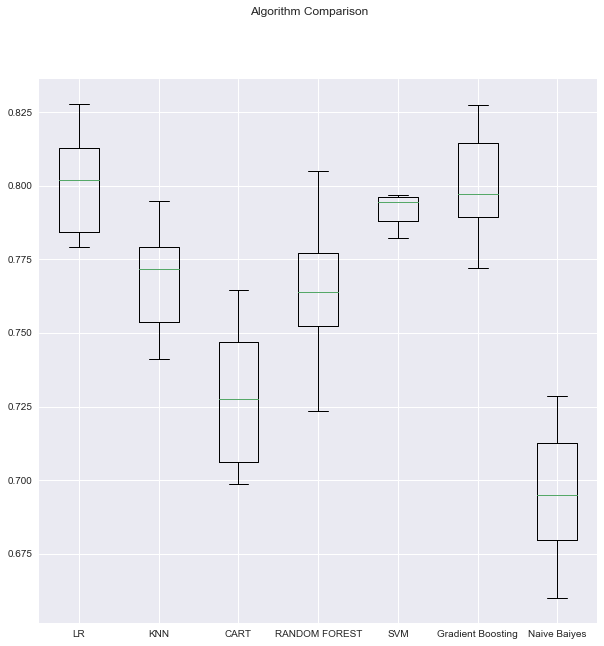

In [20]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()